# Introduction

In this notebook, we are putting Deep Learning models in to practices.

With the dataset of ***360 Fruit***, which includes around a hundred of fruit families with hundreds images for each, we are using:
* A ***handmade-by-me CNN***.
* A state-of-the-OLD-art: ***LeNet5***
* Transform learning with the giant ***ResNet-152***
* Transform learning with the tiny ***SqueezeNet***

Then, each model practicing following by a classification report and a tunning.

At last, we will discuss which one is the best, why, how, and other questions.


***Dataset properties***

* Total number of images: 90483.
* Training set size: 67692 images (one fruit or vegetable per image).
* Test set size: 22688 images (one fruit or vegetable per image).
* Multi-fruits set size: 103 images (more than one fruit (or fruit class) per image)
* Number of classes: ***131*** (fruits and vegetables).
* Image size: ***100x100*** pixels.

# Import Packages

In [1]:
# Bases
import keras as k
import tensorflow as tf
from keras import backend as K

## data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, LayerNormalization, GlobalAveragePooling2D, AveragePooling2D, LeakyReLU, BatchNormalization

## plotting
import os
import numpy as np
import matplotlib.pyplot as plt

## callbacks
from keras.callbacks import TensorBoard
import time

from keras.applications import ResNet152
from keras import Input, Model

import sklearn
from sklearn.metrics import  classification_report, roc_curve

Using TensorFlow backend.


## Environment Configuration for GPU

As the VRAM of GPU is 3GB, not enough to work with cudnn, we will do some tricks force GPU to work.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

memory_limit=1024
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit),
         #tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15379919019655414164
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9778642003384353641
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1073741824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13923085033942487078
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7063604639696430413
physical_device_desc: "device: XLA_GPU device"
]


## Helpful Functions

In [6]:
# This function: plots images in the form of a 1 row x 5 cols grid.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Preprocessing Data

The dataset has the following directory ***structure***:

<pre>
<b>Fruit Images Dataset</b>
|__ <b>train</b>
    |______ <b>Apple Braeburn</b>: [0_100.jpg, ..]
    |______ <b>Apple Crimson Snow</b>: [0_100.jpg, ..] 
    ..
    |______ <b>Apple Watermelon</b>: [0_100.jpg, ..]
|__ <b>test</b>
    |______ <b>Apple Braeburn</b>: [0_100.jpg, ..]
    |______ <b>Apple Crimson Snow</b>: [0_100.jpg, ..] 
    ..
    |______ <b>Apple Watermelon</b>: [0_100.jpg, ..]
</pre>

***How to prepare data***

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`, which can:
* Read images and preprocess them into proper tensors. 
* Set up generators that convert these images into batches of tensors — helpful when training the network.

In [7]:
# Generator
train_generator = ImageDataGenerator(rescale=1/255)
test_generator = ImageDataGenerator(rescale=1/255)

In [8]:
# Variable for pre-processing and training
batch_size = 128
epochs = 15

IMG_HEIGHT = 100
IMG_WIDTH = 100

num_classes = 131

class_mode = 'categorical'

where_train = '/home/maihai/GitHub/Fruit-Images-Dataset/train'
where_test  = '/home/maihai/GitHub/Fruit-Images-Dataset/test'

After defining the generators, the `flow_from_directory` method will:
* Load images from the disk,
* Applies rescaling,
* Applies resizes images into the required dimensions.

In [9]:
# Train set
train_data_gen = train_generator.flow_from_directory(directory=where_train, 
                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                         class_mode=class_mode,
                                         shuffle=False,
                                         batch_size=batch_size)


Found 67692 images belonging to 131 classes.


In [10]:
# Test set
test_data_gen = test_generator.flow_from_directory(directory=where_test,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        class_mode=class_mode,
                                        shuffle=False,
                                        batch_size=batch_size)

Found 22688 images belonging to 131 classes.


In [11]:
# Set variables for model training later

num_train = train_data_gen.samples
num_test  = test_data_gen.samples

## Visualize Images

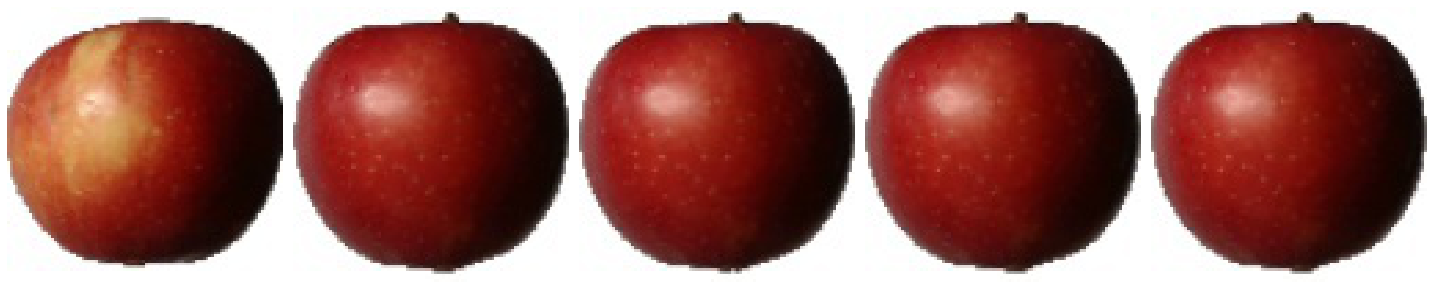

In [12]:
sample_training_images, _ = next(train_data_gen)

plotImages(sample_training_images[:5])

# Model - Version Kaggle

## Creating

In [16]:
model_baseline = Sequential([
    Conv2D(filters=16, kernel_size=2,  activation='relu', padding='same',  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=2,  activation='relu', padding='same'),
    MaxPooling2D(2),
    
    Conv2D(filters=64, kernel_size=2,  activation='relu', padding='same'),
    MaxPooling2D(2),
    
    Conv2D(filters=128, kernel_size=2, activation='relu', padding='same'),
    MaxPooling2D(2),
    Dropout(0.3),
    
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.4),
    
    Dense(131, activation = 'softmax')
])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       3

In [ ]:
model_baseline.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy', 'AUC'])

In [ ]:
# Set up TensorBoard
NAME = 'Handmade_model_baseline_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [ ]:
%%time
# Train model_baseline
history = model_baseline.fit(train_data_gen,
                             steps_per_epoch=num_train // batch_size,
                             epochs=epochs,
                             callbacks=[tensorboard])

In [ ]:
model_baseline.save('baseline_Kaggle.hdf5')

where_to_save = 'baseline_Kaggle_weights'
model_baseline.save_weights(filepath=where_to_save,
                            overwrite=True)

In [ ]:
# Clear VRAM
K.clear_session()

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [23]:
# load the weights that yielded the best validation accuracy
model.load_weights('cnn_from_scratch_fruits.hdf5')

## Learning Curve

In [27]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'auc'])

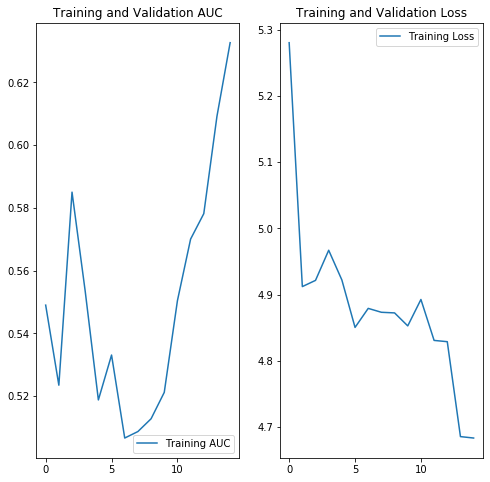

In [28]:
auc = history.history['auc']
#val_auc = history.history['val_auc']

loss=history.history['loss']
#val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
#plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Clasification report

In [ ]:
model_baseline.load_weights('Handmade_model_baseline_weights')

In [24]:
y_pred = model.predict(test_data_gen,
                                
                                    steps=num_test/batch_size,
                                    verbose=1)
y_pred = np.argmax(y_pred, axis=1)

178/177 [==============================] - 10s 57ms/step


In [25]:
y_true = test_data_gen.labels

In [26]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       164
           1       1.00      1.00      1.00       148
           2       1.00      1.00      1.00       160
           3       1.00      1.00      1.00       164
           4       0.93      1.00      0.96       161
           5       0.99      1.00      0.99       164
           6       1.00      1.00      1.00       152
           7       1.00      0.90      0.95       164
           8       0.95      0.98      0.96       164
           9       1.00      0.99      0.99       144
          10       1.00      1.00      1.00       166
          11       1.00      0.99      1.00       164
          12       1.00      1.00      1.00       219
          13       1.00      1.00      1.00       164
          14       1.00      1.00      1.00       143
          15       0.91      1.00      0.95       166
          16       1.00      1.00      1.00       166
          17       0.99    

In [32]:
y_pred[:100]

array([44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
       44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
       44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
       44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
       44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
       44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44])